# Stat Analysis

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon
from datetime import datetime

data = pd.read_csv('/content/drive/MyDrive/chargepoint/Sessions.csv')

In [ ]:
# Calculate the duration column in minutes
data['duration'] = (data['end_ts'] - data['start_ts']) / 60

# Calculate the quartiles and IQR
q1 = data['duration'].quantile(0.25)
q3 = data['duration'].quantile(0.75)
iqr = q3 - q1

# Calculate the lower and upper bounds for outliers
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filter out rows with outliers
filtered_data = data[(data['duration'] >= lower_bound) & (data['duration'] <= upper_bound)]

In [ ]:
duration_stats = filtered_data['duration'].describe()
energy_stats = filtered_data['energy'].describe()

print("Duration Statistics:")
print(duration_stats)
print("Energy Statistics:")
print(energy_stats)


In [ ]:
distinct_users = filtered_data['user_id'].nunique()
# Print the count
print("Number of distinct users:", distinct_users)

Number of distinct users: 2155


In [ ]:
# Calculate the number of charging sessions per user
sessions_per_user = filtered_data['user_id'].value_counts()
# Identify frequent users (top N users with the most sessions)
N = 10  # Number of top users
top_n_users = sessions_per_user.head(N).index.tolist()
print("Frequent users:", top_n_users)
# Calculate the contribution of frequent users to overall energy consumption
energy_contribution = filtered_data.groupby('user_id')['energy'].sum().reset_index()
frequent_users_energy = energy_contribution[energy_contribution['user_id'].isin(top_n_users)]
total_energy = filtered_data['energy'].sum()
contribution = frequent_users_energy['energy'].sum() / total_energy * 100
print("Contribution to overall energy consumption (%):", contribution)

Frequent users: ['f090d40e22', 'da6361e4ad', '742499d3a9', '7ec018e5bf', '792fd87dca', '389f35651b', 'b58d54d5e7', '3b9eec294c', '1057669b4b', '078ea9bdd2']
Contribution to overall energy consumption (%): 23.85961393733433


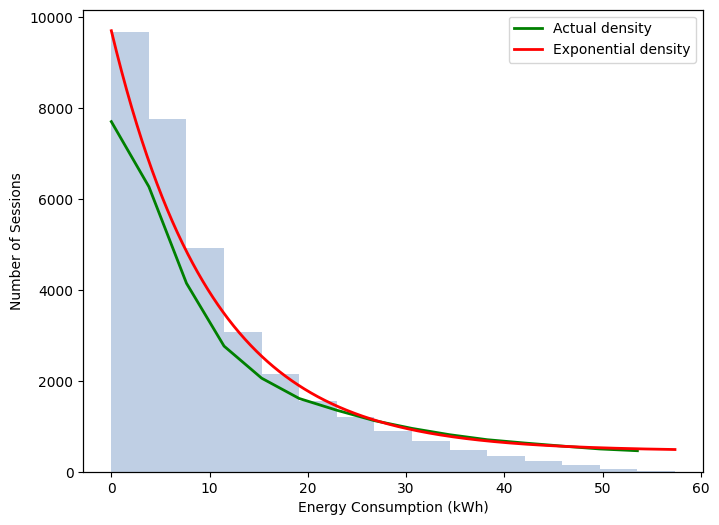

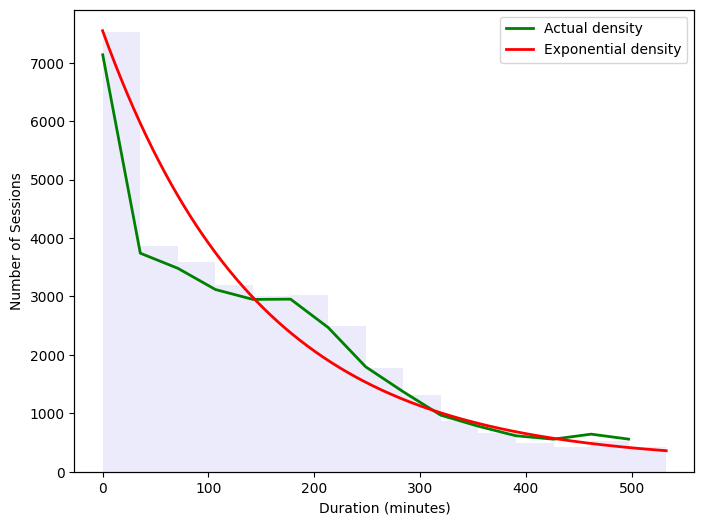

In [21]:
# Figure. Energy Consumption and Duration

# Create the figure and axes
fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()

hist_values, bins, _ = ax1.hist(filtered_data['energy'], bins=15, color='lightsteelblue', density=False, alpha=0.8)
ax1.set_xlabel('Energy Consumption (kWh)')
ax1.set_ylabel('Number of Sessions')

# Calculate exponential distribution parameters
lambda_val = 1 / np.mean(filtered_data['energy'])
x = np.linspace(0, np.max(filtered_data['energy']), 1000)

# Calculate actual density using histogram values
bin_width = bins[1] - bins[0]
actual_density = hist_values / (np.sum(hist_values) * bin_width)
# Plot the actual density curve
ax2.plot(bins[:-1], actual_density, color='green', linewidth=2)
# Overlay the exponential density curve
ax2.plot(x, expon.pdf(x, scale=1 / lambda_val), color='red', linewidth=2)
# ax2.set_ylabel('Density')
# Set the limits for the y-axis on the secondary plot
# ax2.set_ylim(0, np.max(expon.pdf(x, scale=1 / lambda_val)) * 1.2)
ax2.yaxis.set_visible(False)
plt.legend(['Actual density', 'Exponential density'])
plt.show()

# Create the figure and axes
fig, ax3 = plt.subplots(figsize=(8, 6))
ax4 = ax3.twinx()
hist_values, bins, _ = ax3.hist(filtered_data['duration'], bins=15, color='lavender', density=False, alpha=0.8)
ax3.set_xlabel('Duration (minutes)')
ax3.set_ylabel('Number of Sessions')
lambda_val = 1 / np.mean(filtered_data['duration'])
x = np.linspace(0, np.max(filtered_data['duration']), 1000)
bin_width = bins[1] - bins[0]
actual_density = hist_values / (np.sum(hist_values) * bin_width)
ax4.plot(bins[:-1], actual_density, color='green', linewidth=2)
ax4.plot(x, expon.pdf(x, scale=1 / lambda_val), color='red', linewidth=2)
# ax4.set_ylabel('Density')
# ax4.set_ylim(0, np.max(expon.pdf(x, scale=1 / lambda_val)) * 1.2)
ax4.yaxis.set_visible(False)
plt.legend(['Actual density', 'Exponential density'])
plt.show()


In [ ]:
station_usage = filtered_data.groupby('station_id').size().reset_index(name='total_sessions')
station_names = station_usage['station_id'].unique()
plt.figure(figsize=(10, 6))
plt.bar(station_usage['station_id'], station_usage['total_sessions'])
plt.xlabel('Station ID')
plt.ylabel('Total Sessions')
plt.title('Number of Sessions per Station')
plt.xticks(station_usage.index, [f"Station {i+1}" for i in range(len(station_names))], rotation=45)
plt.show()

In [ ]:
grouped = filtered_data.groupby(['station_id', 'port_no']).size().reset_index(name='total_sessions')

# Get the unique station names and port numbers
station_names = grouped['station_id'].unique()
port_numbers = grouped['port_no'].unique()

# Set up the bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Define the width of each bar
bar_width = 0.35

# Set the positions of the bars on the x-axis
x_pos = np.arange(len(station_names))

# Plot the bars for each port
for i, port in enumerate(port_numbers):
    port_data = grouped[grouped['port_no'] == port]['total_sessions']
    ax.bar(x_pos + i * bar_width, port_data, width=bar_width, label=f'Port {port}')

# Set the x-axis tick positions and labels
ax.set_xticks(x_pos)
ax.set_xticklabels([f"Station {i+1}" for i in range(len(station_names))], rotation=45)

# Set the x-axis and y-axis labels
ax.set_xlabel('Charging Station')
ax.set_ylabel('Number of Sessions')
# Add a legend
ax.legend()

# Show the plot
plt.show()

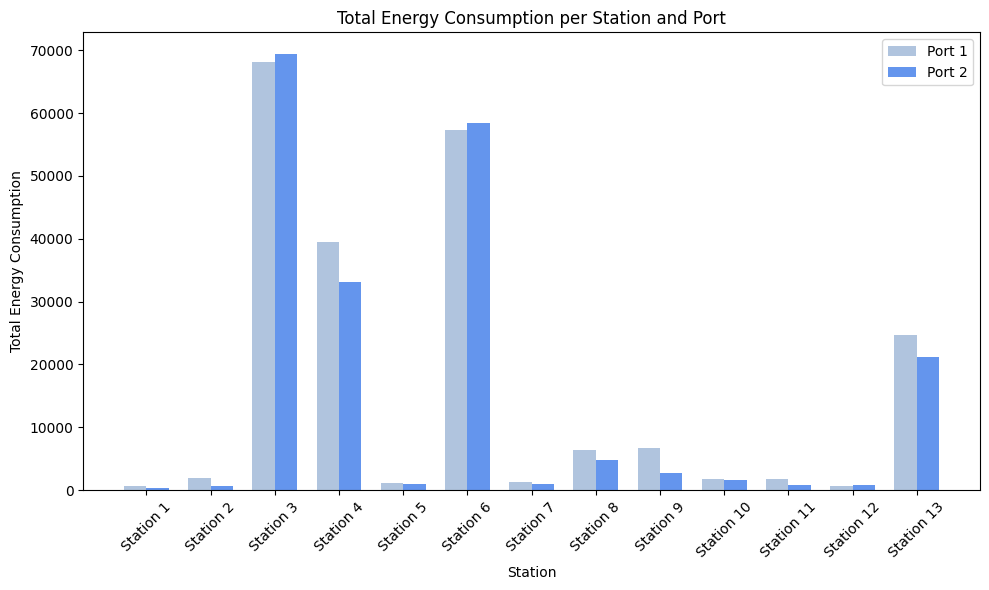

In [ ]:
# Calculate the number of charging sessions and total energy consumption per station and port
station_port_summary = data.groupby(['station_id', 'port_no']).agg(total_energy=('energy', 'sum')).reset_index()
# Get the unique station names
station_names = station_port_summary['station_id'].unique()

# Set up the bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Define the width of each bar
bar_width = 0.35

# Set the positions of the bars on the x-axis
x_pos = np.arange(len(station_names))

# Plot the bars for port 1
port_1_data = station_port_summary[station_port_summary['port_no'] == 1]['total_energy']
ax.bar(x_pos, port_1_data, width=bar_width, color='lightsteelblue', label='Port 1')

# Plot the bars for port 2
port_2_data = station_port_summary[station_port_summary['port_no'] == 2]['total_energy']
ax.bar(x_pos + bar_width, port_2_data, width=bar_width, color='cornflowerblue', label='Port 2')

# Set the x-axis tick positions and labels
ax.set_xticks(x_pos + bar_width / 2)
ax.set_xticklabels([f"Station {i+1}" for i in range(len(station_names))], rotation=45)

# Set the x-axis and y-axis labels
ax.set_xlabel('Station')
ax.set_ylabel('Total Energy Consumption')
ax.set_title('Total Energy Consumption per Station and Port')

# Add a legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
dataset = filtered_data.copy()
# Convert timestamp columns to datetime format
dataset['start_ts'] = dataset['start_ts'].apply(datetime.utcfromtimestamp)
dataset['end_ts'] = dataset['end_ts'].apply(datetime.utcfromtimestamp)

print(dataset.start_ts.min(), dataset.start_ts.max())

In [ ]:
# Figure. Station and energy usage

dataset = filtered_data.copy()

dataset['hour_st'] = pd.to_datetime(dataset['start_dt']).apply(lambda x : x.hour)
dataset['hour_ed'] = pd.to_datetime(dataset['end_dt']).apply(lambda x : x.hour)

# Create time slots for the bar chart
time_slots = np.arange(0, 24, 1)
usage_counts_st = dataset.groupby('hour_st').size().reset_index(name='session_count')
usage_counts_ed = dataset.groupby('hour_ed').size().reset_index(name='session_count')

usage_energy = dataset.groupby('hour_st').agg({'energy': 'mean'})
usage_energy.columns = ['mean_energy']
usage_energy.reset_index(inplace=True)

# Create a line plot using matplotlib
plt.plot(usage_counts_st['hour_st'], usage_counts_st['session_count'], color='red', label='Session (start)')
plt.plot(usage_counts_ed['hour_ed'], usage_counts_ed['session_count'], color='blue', label='Session (end)')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Sessions')
plt.legend(loc='upper left')


# Create a bar plot using matplotlib
plt.figure()
plt.bar(usage_energy['hour_st'], usage_energy['mean_energy'], color='lightsteelblue')
plt.xlabel('Hour of Day')
plt.ylabel('Mean Energy Consumption (kWh)')
# plt.title('Mean Energy Consumption by Hour of Day')
plt.show()